In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, scipy.io as sio
import os, glob
from neo.io import BlackrockIO
import h5py

In [2]:
patient = 12

### load QC to flag channels with artifacts

In [3]:
pt_df = pd.read_csv(f'../../results/2025{patient}/records/QC_pt{patient}.csv')

# create boolean drift col which contains 1 if the 'notes' col contains 'drift'
pt_df['drift_flag'] = pt_df['notes'].apply(
    lambda x: 1 if 'drift' in str(x).lower() else 0
)

drift_chanIDs = pt_df.loc[pt_df['drift_flag'] == 1, 'chanID'].astype(int).tolist()
drift_chanIDs = np.unique(drift_chanIDs)
print(f'chanIDs with possible artifacts: {drift_chanIDs}')

# display
pt_df[pt_df['drift_flag'] == 1]

chanIDs with possible artifacts: [ 97 105 106 107 109 111 112 113]


,chanID,unitID,keep,notes,drift_flag
0,97,596,NaN,FR; drift,1
19,105,1892,1.0,drift,1
20,105,1938,1.0,drift,1
22,106,2448,1.0,drift,1
23,106,2455,1.0,drift,1
28,107,1776,1.0,drift,1
36,109,1763,1.0,drift,1
44,111,1953,0.5,drift,1
46,111,1972,0.5,drift,1
49,112,2226,0.5,drift,1


### load trig times restrict signal to session

In [4]:
nev_file = glob.glob(f'../../results/2025{patient}/raw/*.nev')[0]
io = BlackrockIO(nev_file)
seg = io.read_block(lazy=False).segments[0]
dig_ev = [ev for ev in seg.events if "digital" in ev.name.lower()][0]

# map codes to labels
code_map = {
    10: "block started",
    20: "baseline started",
    30: "stim started",
    40: "delay started",
    50: "task started",
    51: "marker moved",
    52: "left pressed",
    53: "left released",
    54: "right pressed",
    55: "right released",
    56: "response submitted",
    60: "anticipation started",
    70: "feedback started",
    80: "block ended",
}

# build df
df_trigs = pd.DataFrame({
    "trigger_code": dig_ev.labels.astype(int),
    "time": dig_ev.times.magnitude
})
df_trigs["event"] = df_trigs["trigger_code"].map(code_map)

# get session start and end times
sess_start_time = df_trigs.loc[df_trigs["event"] == "block started", "time"].min()
print(f'start of session at {sess_start_time} s')
print(df_trigs.head(10))
sess_end_time = df_trigs.loc[df_trigs["event"] == "block ended", "time"].max()
print(f'end of session at {sess_end_time} s')
print(df_trigs.tail(10))    

start of session at 36.37996666666667 s
   trigger_code       time             event
0            20   0.475033  baseline started
1            30   1.408933      stim started
2            40   2.392100     delay started
3            10  36.379967     block started
4            20  70.978933  baseline started
5            30  71.864133      stim started
6            40  72.858367     delay started
7            50  74.342867      task started
8            51  75.375000      marker moved
9            52  75.375133      left pressed
end of session at 1613.2374333333332 s
      trigger_code         time                 event
2447            30  1608.433967          stim started
2448            40  1609.431467         delay started
2449            50  1610.816733          task started
2450            51  1611.714800          marker moved
2451            52  1611.714933          left pressed
2452            53  1611.848133         left released
2453            56  1611.981533    response subm

### load example channel raw .mat

#samples: 48890791
sampling freq: 30000.0
signal dur: 1629.6930333333332


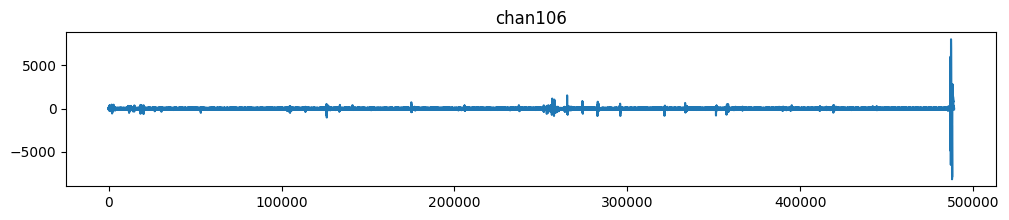

In [5]:
chanID = 106
chan_mat_file = glob.glob(f'../../results/2025{patient}/osort_mat/nsx2mat/*{chanID}*.mat')[0]

# load
with h5py.File(chan_mat_file, "r") as f:

    raw_sig = np.array(f["data"]).squeeze()
    sig_freq = float(np.array(f["MetaTags/SamplingFreq"]).squeeze())
    sig_dur = raw_sig.shape[0] / sig_freq

print(f'#samples: {raw_sig.shape[0]}')
print(f'sampling freq: {sig_freq}')
print(f'signal dur: {sig_dur}')
every_nth = 100  # for plotting
plt.figure(figsize=(12,2))
plt.plot(raw_sig[::every_nth])  # downsample for faster plotting
plt.title(f'chan{chanID}')
plt.show()

### locate problematic time period

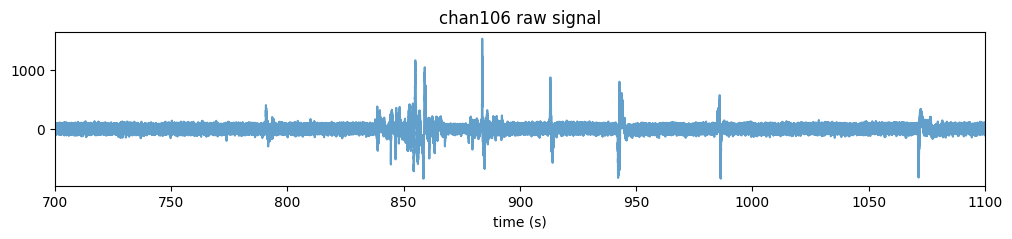

In [6]:
# determine time window to plot
# 0, 500; 700, 1100; 0, sig_dur; 1500, sig_dur
start_time, end_time = 700, 1100 # seconds
start_sampl, end_sampl = int(start_time*sig_freq), int(end_time*sig_freq)
samples_in_secs = np.arange(start_sampl, end_sampl) / sig_freq

every_nth = 100  # for plotting
plt.figure(figsize=(12,2))
plt.plot(samples_in_secs[::every_nth],
         raw_sig[start_sampl:end_sampl][::every_nth], label='raw', alpha=0.7)
plt.xlim(start_time, end_time)
plt.title(f'chan{chanID} raw signal')
plt.xlabel('time (s)')
plt.show()


### clean signal

#outliers: 251127
#noisy: 38486


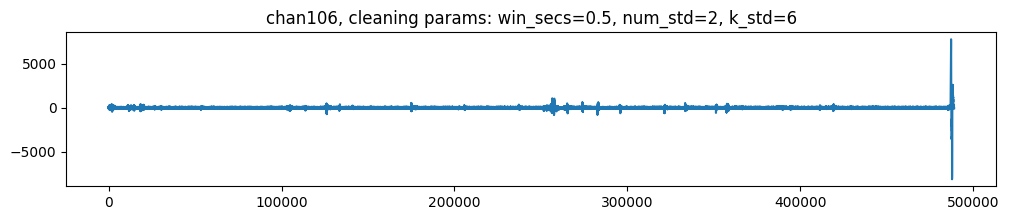

In [7]:
from scipy.ndimage import median_filter

def get_clean_sig(raw_sig, win_secs, num_std, k_std):

    raw_sig = np.asarray(raw_sig, dtype=float).ravel() # flatten

    win = int(win_secs * sig_freq) # secs to samples
    if win % 2 == 0: win += 1 # median filters require odd window length

    # local statistics
    local_med = median_filter(raw_sig, size=win)
    local_mad = median_filter(np.abs(raw_sig - local_med), win) # median absolute deviation
    local_std = 1.4826 * local_mad + 1e-9 # MAD to std, and prevent 0 division

    z = (raw_sig - local_med) / local_std
    outliers = np.abs(z) > num_std      # mask of bad points
    noisy = local_std > (k_std * np.median(local_std))
    print(f'#outliers: {np.sum(outliers)}')
    print(f'#noisy: {np.sum(noisy)}')

    bad = outliers | noisy
    
    good_idx = np.where(~bad)[0]
    bad_idx  = np.where(bad)[0]

    # interpolate to replace bad
    clean_sig = raw_sig.copy()
    clean_sig[bad] = np.interp(bad_idx, good_idx, raw_sig[~bad])
    return clean_sig

# cleaning params
win_secs, num_std, k_std = .5, 2, 6
clean_sig = get_clean_sig(raw_sig, win_secs=win_secs, num_std=num_std, k_std=k_std)

every_nth = 100  # for plotting
plt.figure(figsize=(12,2))
plt.plot(clean_sig[::every_nth])
plt.title(f'chan{chanID}, cleaning params: win_secs={win_secs}, num_std={num_std}, k_std={k_std}')
# makedir
os.makedirs(f'../../results/2025{patient}/records/figs/', exist_ok=True)
# plt.savefig(f'../../results/2025{patient}/records/figs/chan{chanID}_win_sec{win_secs}_std{num_std}.png', bbox_inches='tight')
plt.show()


### replot problematic time period, now in clean signal

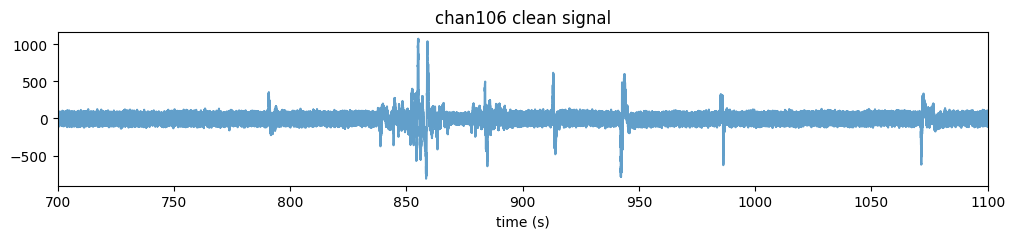

In [8]:
# determine time window to plot
# 0, 500; 700, 1100; 0, sig_dur; 1500, sig_dur
start_time, end_time = 700, 1100 # seconds
start_sampl, end_sampl = int(start_time*sig_freq), int(end_time*sig_freq)
samples_in_secs = np.arange(start_sampl, end_sampl) / sig_freq

every_nth = 100  # for plotting
plt.figure(figsize=(12,2))
plt.plot(samples_in_secs[::every_nth],
         clean_sig[start_sampl:end_sampl][::every_nth],alpha=0.7)
plt.xlim(start_time, end_time)
plt.title(f'chan{chanID} clean signal')
plt.xlabel('time (s)')
plt.show()


### write out clean signal

In [9]:
out_dir = f'../../results/2025{patient}/osort_mat_clean/sigs/'
os.makedirs(out_dir, exist_ok=True)
# sio.savemat(f'{out_dir}{chanID}_std{num_std}_on_trim{to_trim}.mat', {'data': clean_sig})
